In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit
from numpy.random import normal

from lightkurve import KeplerLightCurveFile

from evilmc import evparams, evmodel, convert_Kz
from transit_utils import bindata, transit_duration
from variable_eclipses_utils import retreive_data

KIC = 4570949

eclipse_depth = 50e-6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# The system parameters as reported in Faigler et al. (2013) --
#  http://iopscience.iop.org/article/10.1088/0004-637X/771/1/26/meta
a = 1./0.221 #± 0.003
b = 0.944 # ± 0.011
inc = 78.0 # ± 0.2
per = 1.54492875*u.day # ± 0.00000027
Kz_m_per_s = 308. # ± 20.
Kz = convert_Kz(Kz=Kz_m_per_s) # convert to fraction of the speed of light

Mp = 2.00*u.jupiterMass # ± 0.26
Rp_over_a = 0.0214 # ± 0.0008
Rp_over_Rs = Rp_over_a*a
Ms = 1.2*u.solMass # ± 0.2
q = (Mp.to('kg')/Ms.to('kg')).value

vsini = 6500.*u.m/u.s # ± 2000
Rs = 1.32*u.solRad #± 0.08
Omegas = vsini.to('m/s')/Rs.to('m')*per.to('s') # stellar rotation state - very little effect, so chosen arbitrarily

Ts = 6300. # ± 200
Faigler_T0 = (737.49 + 2455000. - 2454833.)# % per.to('day').value # ±0.19
T0 = 0.68508434

coeffs = [0.313, 0.304]

Aplanet = 60.4e-6 # ± 2.0
F0 = 60.4e-6 # ± 2.0 -- overall shift in light curve, which is arbitrary
phase_shift = -10.3/360. # ± 2.0 - convert phase shift angle from degrees to orbital phase

beta = 0.0716671 # Interpolation from among the values reported in Claret & Bloemen (2011) A&A 529, 75

# Save parameters to an evilmc parameters object
saved_ep = evparams(per=per.to('day').value, a=a, T0=T0, p=Rp_over_Rs, limb_dark="quadratic", b=b, 
                    F0=F0, Aplanet=Aplanet, phase_shift=phase_shift, beta=beta, q=q, Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], 
                    u=coeffs)

In [4]:
# 2018 Sep 5 - As a way of minimizing compute time while maximizing the eclipse signal, 
#   I'll take a binsize of 30-min and a boxcar window size equal to one orbital period.
num_period = 1
binsize = 30./60./24.
    
# Retrieve while masking out transit
time, flux, filtered_time, filtered_flux = retreive_data(saved_ep.per, num_periods=num_period, 
                                                         KIC=KIC, fit_bottom=True, params=saved_ep, drop_outliers=True)
folded_time = filtered_time % saved_ep.per

# Estimate scatter
dur = transit_duration(saved_ep)
ind = ~(np.abs(folded_time - saved_ep.T0) < dur)
unbinned_noise = mad(filtered_flux[ind])
print(unbinned_noise*1e6)

141.83679022846897


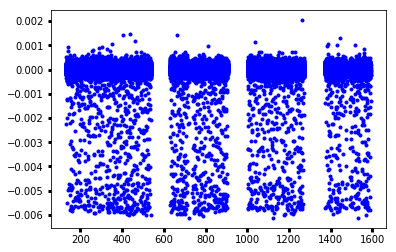

In [5]:
# Initial fit using Faigler's parameters (with my own T0)
plt.plot(filtered_time, filtered_flux, 'b.')

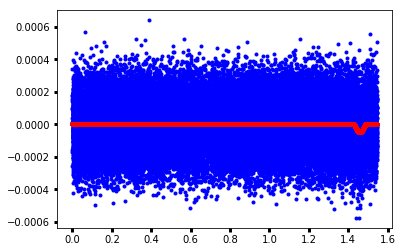

In [9]:
def fit_eclipse(time, cur_eclipse_depth, supersample_factor=100, exp_time=30./60./24.):
    cur_ep = evparams(per=saved_ep.per, a=saved_ep.a, T0=saved_ep.T0, p=saved_ep.p, limb_dark="quadratic", 
                      b=saved_ep.b, beta=saved_ep.beta, Ts=Ts, Ws=[0.,0., Omegas], u=saved_ep.u,
                      q=saved_ep.q, Kz=saved_ep.Kz, F0=saved_ep.F0, Aplanet=saved_ep.Aplanet, 
                      phase_shift=saved_ep.phase_shift)

    em = evmodel(time, cur_ep, supersample_factor=supersample_factor, exp_time=exp_time)
    
    return em.calc_eclipse(cur_eclipse_depth)

synthetic_eclipse = fit_eclipse(filtered_time, eclipse_depth)
noisy_synthetic_eclipse = synthetic_eclipse + normal(size=len(synthetic_eclipse), scale=unbinned_noise)

plt.plot(folded_time, noisy_synthetic_eclipse, 'b.')
plt.plot(folded_time, synthetic_eclipse, 'r.')

5e-05
[5.63039011e-05]
[1.40281193]


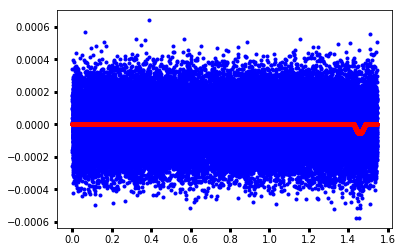

In [10]:
time = folded_time
data = noisy_synthetic_eclipse

initial_guess = [0.]
eclipse_popt, eclipse_pcov = curve_fit(fit_eclipse, time, data, sigma=unbinned_noise*np.ones_like(time),
                                       p0=initial_guess, 
                                       bounds=(-1000e-6, 1000e-6))
print(eclipse_depth)
print(eclipse_popt)
print(np.abs(eclipse_popt[0] - eclipse_depth)/np.sqrt(eclipse_pcov.diagonal()))

plt.plot(time, data, 'b.')
plt.plot(time, fit_eclipse(time, *eclipse_popt), 'r.')

4.9829692319775456e-05


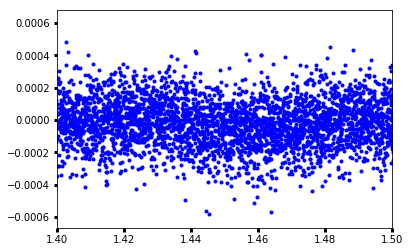

In [41]:
# Now I'd like to make the eclipse depth vary sinusoidally from orbit to orbit, stack the eclipses all together,
# and see what eclipse depth I get.
which_orbit = np.floor((filtered_time - Faigler_T0)/saved_ep.per)
which_orbit -= np.min(which_orbit)
which_orbit_unq = np.unique(which_orbit)
which_orbit_midtime = which_orbit_unq*saved_ep.per

eclipse_variability_period = 10.*saved_ep.per # eclipse depth will vary with a period equal to 10 orbits
eclipse_variability_amplitude = eclipse_depth
eclipse_depths = eclipse_variability_amplitude*(1. + np.sin(2.*np.pi/eclipse_variability_period*which_orbit_midtime))

synthetic_eclipses = np.zeros_like(filtered_time)
noisy_synthetic_eclipses = np.zeros_like(filtered_time)
for i in range(len(which_orbit_unq)-1):
    mn = which_orbit_unq[i]*saved_ep.per + np.min(filtered_time)
    mx = (which_orbit_unq[i] + 1)*saved_ep.per + np.min(filtered_time)
    
    ind = (filtered_time >= mn) & (filtered_time < mx)
    synthetic_eclipses[ind] = fit_eclipse(filtered_time[ind], eclipse_depths[i])
    noisy_synthetic_eclipses[ind] = synthetic_eclipses[ind] +\
        normal(size=len(synthetic_eclipses[ind]), scale=unbinned_noise)
    
plt.plot(folded_time, noisy_synthetic_eclipses, 'b.')
#plt.plot(folded_time, synthetic_eclipses, 'r.')
plt.xlim([1.4, 1.5])

mn = np.mean(eclipse_depths)
print(mn)

(5e-05, 4.9829692319775456e-05)
[5.63039011e-05]
[1.44071063]


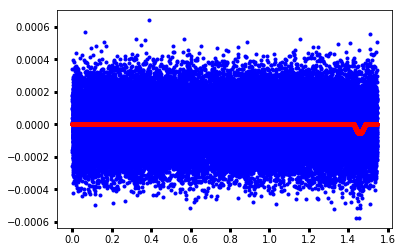

In [42]:
time = folded_time
data = noisy_synthetic_eclipse

initial_guess = [0.]
eclipse_popt, eclipse_pcov = curve_fit(fit_eclipse, time, data, sigma=unbinned_noise*np.ones_like(time),
                                       p0=initial_guess, 
                                       bounds=(-1000e-6, 1000e-6))
print(eclipse_variability_amplitude, mn)
print(eclipse_popt)
print((eclipse_popt[0] - mn)/np.sqrt(eclipse_pcov.diagonal()))

plt.plot(time, data, 'b.')
plt.plot(time, fit_eclipse(time, *eclipse_popt), 'r.')

# 2018 Sep 20 -
# (5e-05, 4.9829692319775456e-05)
# [5.63039011e-05]
# [1.44071063]
#
# Seems consistently above the average!

5.8647031303175976e-05


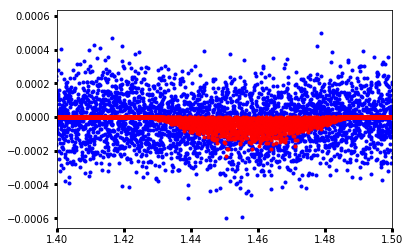

In [49]:
# 2018 Sep 20 - Just as a check, let's try a more complicated behavior.
# Now I'd like to make the eclipse depth vary sinusoidally from orbit to orbit, stack the eclipses all together,
# and see what eclipse depth I get.
which_orbit = np.floor((filtered_time - Faigler_T0)/saved_ep.per)
which_orbit -= np.min(which_orbit)
which_orbit_unq = np.unique(which_orbit)
which_orbit_midtime = which_orbit_unq*saved_ep.per

eclipse_variability_period = 10.*saved_ep.per # eclipse depth will vary with a period equal to 10 orbits
eclipse_variability_amplitude = eclipse_depth
eclipse_depths = np.abs(eclipse_variability_amplitude + normal(size=len(which_orbit_midtime), 
                                                         scale=eclipse_variability_amplitude))

synthetic_eclipses = np.zeros_like(filtered_time)
noisy_synthetic_eclipses = np.zeros_like(filtered_time)
for i in range(len(which_orbit_unq)-1):
    mn = which_orbit_unq[i]*saved_ep.per + np.min(filtered_time)
    mx = (which_orbit_unq[i] + 1)*saved_ep.per + np.min(filtered_time)
    
    ind = (filtered_time >= mn) & (filtered_time < mx)
    synthetic_eclipses[ind] = fit_eclipse(filtered_time[ind], eclipse_depths[i])
    noisy_synthetic_eclipses[ind] = synthetic_eclipses[ind] +\
        normal(size=len(synthetic_eclipses[ind]), scale=unbinned_noise)
    
plt.plot(folded_time, noisy_synthetic_eclipses, 'b.')
plt.plot(folded_time, synthetic_eclipses, 'r.')
plt.xlim([1.4, 1.5])

men = np.mean(eclipse_depths)
print(men)

5.8647031303175976e-05
[5.63039011e-05]
[-0.52141857]


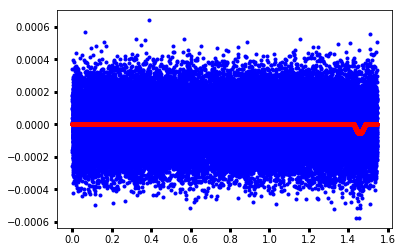

In [50]:
time = folded_time
data = noisy_synthetic_eclipse

initial_guess = [0.]
eclipse_popt, eclipse_pcov = curve_fit(fit_eclipse, time, data, sigma=unbinned_noise*np.ones_like(time),
                                       p0=initial_guess, 
                                       bounds=(-1000e-6, 1000e-6))
print(men)
print(eclipse_popt)
print((eclipse_popt[0] - men)/np.sqrt(eclipse_pcov.diagonal()))

plt.plot(time, data, 'b.')
plt.plot(time, fit_eclipse(time, *eclipse_popt), 'r.')

# 2018 Sep 20
# (5.7880851691646565e-05
# [5.63039011e-05]
# [-0.35092003]
# Seems often below the average but not by much!

(678, 731)


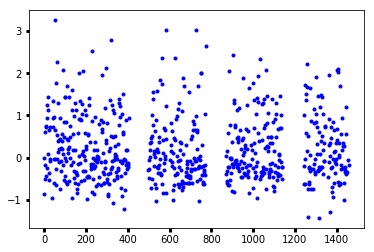

In [86]:
# eclipse_ind = (eclipse_depths/unbinned_noise > 0.5) & (eclipse_depths/unbinned_noise < 1)

# fit_eclipse_depths = np.array([])
# fit_eclipse_depth_errs = np.array([])
# for cur_which_orbit in which_orbit_unq:
#     mn = cur_which_orbit*saved_ep.per + np.min(filtered_time)
#     mx = (cur_which_orbit + 1)*saved_ep.per + np.min(filtered_time)
    
#     ind = (filtered_time >= mn) & (filtered_time < mx)
#     time = filtered_time[ind] % saved_ep.per
#     data = noisy_synthetic_eclipses[ind]
    
#     initial_guess = [0.]
#     try:
#         eclipse_popt, eclipse_pcov = curve_fit(fit_eclipse, time, data, sigma=unbinned_noise*np.ones_like(time),
#                                                p0=initial_guess, bounds=(-1000e-6, 1000e-6))
#         fit_eclipse_depths = np.append(fit_eclipse_depths, eclipse_popt[0])
#         fit_eclipse_depth_errs = np.append(fit_eclipse_depth_errs, np.sqrt(eclipse_pcov[0,0]))
#     except:
#         fit_eclipse_depths = np.append(fit_eclipse_depths, 0.)
#         fit_eclipse_depth_errs = np.append(fit_eclipse_depth_errs, 0.)
        
# plt.errorbar(eclipse_depths*1e6, fit_eclipse_depths*1e6, fit_eclipse_depth_errs*1e6, ls='')
# plt.plot(eclipse_depths*1e6, eclipse_depths*1e6, 'k')

ind = fit_eclipse_depth_errs > 1e-8

y = (fit_eclipse_depths[ind] - eclipse_depths[ind])/fit_eclipse_depth_errs[ind]
print(y[np.abs(y) < 3.].size, which_orbit_midtime.size)
plt.plot(which_orbit_midtime[ind], y, 'b.')

# 2018 Sep 20
# Strangely, the fitting tends to OVER- rather than underestimate the eclipse depth. Not sure why.
#
# In any case, if you know all the other system parameters, you are able to retreive the majority of eclipses
#   to at least 3-sigma.

[9.58059418e-05 6.72515916e-05]
[4.97408090e-06 1.36599578e-06]


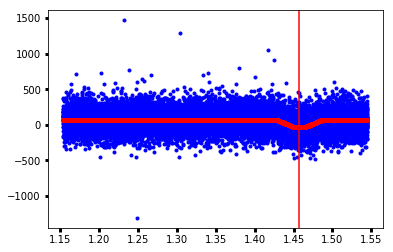

In [120]:
# 2018 Sep 20
# Now what happens if I include the EVILMC signals? Can I ignore the EVs and fit the region very close to the eclipse?
def fit_eclipse_with_baseline(time, cur_eclipse_depth, baseline, supersample_factor=100, exp_time=30./60./24.):
    cur_ep = evparams(per=saved_ep.per, a=saved_ep.a, T0=saved_ep.T0, p=saved_ep.p, limb_dark="quadratic", 
                      b=saved_ep.b, beta=saved_ep.beta, Ts=Ts, Ws=[0.,0., Omegas], u=saved_ep.u,
                      q=saved_ep.q, Kz=saved_ep.Kz, F0=saved_ep.F0, Aplanet=saved_ep.Aplanet, 
                      phase_shift=saved_ep.phase_shift)

    em = evmodel(time, cur_ep, supersample_factor=supersample_factor, exp_time=exp_time)
    
    return em.calc_eclipse(cur_eclipse_depth) + baseline

ind = np.abs(folded_time - (saved_ep.T0 + 0.5*saved_ep.per)) < 5*dur

time = folded_time[ind]
data = filtered_flux[ind]
err = unbinned_noise*np.ones_like(time)

initial_guess = [0., 60e-6]
eclipse_popt, eclipse_pcov = curve_fit(fit_eclipse_with_baseline, time, data, sigma=unbinned_noise*np.ones_like(time),
                                       p0=initial_guess, 
                                       bounds=([-1000e-6, -100e-6], [1000e-6, 100e-6]))
print(eclipse_popt)
print(np.sqrt(eclipse_pcov.diagonal()))

plt.plot(time, data*1e6, 'b.')
plt.plot(time, fit_eclipse_with_baseline(time, *eclipse_popt)*1e6, 'r.')
plt.axvline((saved_ep.T0 + 0.5*saved_ep.per), color='red')

# ind = np.abs(folded_time - (saved_ep.T0 + 0.5*saved_ep.per)) < dur
# [9.27888530e-05 6.48234436e-05]
# [5.97656200e-06 2.94161048e-06]

# ind = np.abs(folded_time - (saved_ep.T0 + 0.5*saved_ep.per)) < 1.5*dur
# [9.31620109e-05 6.51239314e-05]
# [5.40198975e-06 2.19202978e-06]

# ind = np.abs(folded_time - (saved_ep.T0 + 0.5*saved_ep.per)) < 2*dur
# [9.53265774e-05 6.68660550e-05]
# [5.27390003e-06 1.98030160e-06]

# ind = np.abs(folded_time - (saved_ep.T0 + 0.5*saved_ep.per)) < 3*dur
# [9.59535730e-05 6.73704569e-05]
# [5.09565225e-06 1.68502914e-06]

# ind = np.abs(folded_time - (saved_ep.T0 + 0.5*saved_ep.per)) < 5*dur
# [9.58059418e-05 6.72515916e-05]
# [4.97408090e-06 1.36599578e-06]